<a href="https://colab.research.google.com/github/zoe-weinstein/ENVIR-458/blob/main/Homework9_Weinstein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework Assignment: Machine Learning for Solar Radiation Prediction



Background Story:
You are a machine learning engineer working with atmospheric scientists to better understand how solar radiation is impacted by atmospheric conditions. Your dataset, SW_with_AOD.csv, contains observed surface radiation and related atmospheric properties such as aerosol optical depth (AOD), cloud fraction, total ozone, and surface reflectance.

Your task is to build models to predict the amount of incoming shortwave radiation and to categorize total incoming radiation into groups using clustering and classification techniques.

* SZA: Solar Zenith Angle

* AOD: Aerosol Optical Depth

* COD: Cloud Optical Depth

* CLD_FRAC: Cloud Fraction

* UW: Water vapor column

* TO3: Total Ozone

* Pressure: Surface Pressure

* BSA: Black Sky Albedo

* WSA: White Sky Albedo

Targets:

* SW_direct: Direct Shortwave Radiation

* SW_diffuse: Diffuse Shortwave Radiation

In [329]:
import pandas as pd

## Part 1: Data Preprocessing (1 point)

In [330]:
df = pd.read_csv('SW_with_AOD.csv')

In [331]:
df.head()

,SZA,AOD,COD,CLD_FRAC,UW,TO3,Pressure,BSA,WSA,SW_direct,SW_diffuse
0,24.936783,1.172892,2.440000,0.286546,2.021502,311.419861,959.085083,0.162,0.193,467.191650,300.820007
1,34.865055,1.626954,4.630000,0.468832,4.859887,308.713379,968.427551,0.155,0.169,264.900024,385.293335
2,27.330978,1.095007,2.030000,0.301414,5.278558,293.322052,988.040588,0.136,0.149,313.553314,321.538361
3,20.361732,1.126541,5.500000,0.377019,4.856422,321.498199,977.610229,0.156,0.179,143.902298,501.073639
4,13.433228,0.725452,0.736076,0.075378,0.644262,295.448975,882.321411,0.188,0.212,957.331665,79.003334


In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35224 entries, 0 to 35223
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SZA         35224 non-null  float64
 1   AOD         35224 non-null  float64
 2   COD         35224 non-null  float64
 3   CLD_FRAC    35224 non-null  float64
 4   UW          35224 non-null  float64
 5   TO3         35224 non-null  float64
 6   Pressure    35224 non-null  float64
 7   BSA         35224 non-null  float64
 8   WSA         35224 non-null  float64
 9   SW_direct   35224 non-null  float64
 10  SW_diffuse  35224 non-null  float64
dtypes: float64(11)
memory usage: 3.0 MB


In [333]:
# check for missing variables
print(df.isnull().sum())
# check to see if median and mean are close
print(df.mean())
print(df.median())
# because mean and median values are close, this means there likely are not outlier values that are skewing the mean

SZA           0
AOD           0
COD           0
CLD_FRAC      0
UW            0
TO3           0
Pressure      0
BSA           0
WSA           0
SW_direct     0
SW_diffuse    0
dtype: int64
SZA            43.955300
AOD             0.607132
COD             1.386743
CLD_FRAC        0.146884
UW              2.272496
TO3           296.895774
Pressure      958.845881
BSA             0.160722
WSA             0.173584
SW_direct     450.597469
SW_diffuse    178.151183
dtype: float64
SZA            45.385958
AOD             0.399925
COD             0.809864
CLD_FRAC        0.095963
UW              2.011255
TO3           294.010345
Pressure      974.347961
BSA             0.158000
WSA             0.173000
SW_direct     455.886505
SW_diffuse    151.666077
dtype: float64


In [334]:
# Create a new column: SW_total = SW_direct + SW_diffuse
df["SW_total"] = df["SW_direct"] + df["SW_diffuse"]

In [335]:
# Create a new categorical column: SW_total_category
q1 = df["SW_total"].quantile(0.25)
q2 = df["SW_total"].median()
q3 = df["SW_total"].quantile(0.75)
print("min:", df["SW_total"].min(), "q1:", q1, "q2:", q2, "q3", q3, "max", df["SW_total"].max())
df["SW_total_category"] = pd.cut(df["SW_total"], bins=[0, q1, q2, q3, df["SW_total"].max()], labels=["q1", "q2", "q3", "q4"])
df[["SW_total", "SW_total_category"]]

min: 0.764696598 q1: 466.96225165 q2: 635.24290465 q3 800.357952165 max 1175.2438508


,SW_total,SW_total_category
0,768.011658,q3
1,650.193359,q3
2,635.091675,q2
3,644.975937,q3
4,1036.334999,q4
...,...,...
35219,682.305633,q3
35220,456.540008,q1
35221,397.228920,q1
35222,436.438309,q1


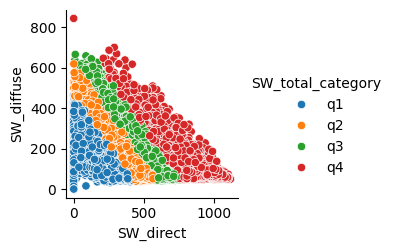

In [336]:
# Visual Exploration with Pairplot: Use Seaborn’s pairplot to visualize relationships among all features, including: All input variables
import seaborn as sns
sns.pairplot(df, x_vars= "SW_direct", y_vars = "SW_diffuse", hue= "SW_total_category")

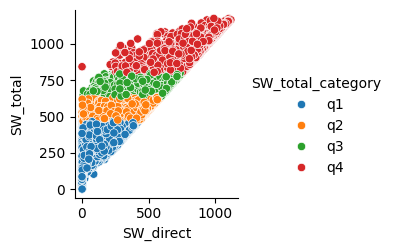

In [337]:
sns.pairplot(df, x_vars= "SW_direct", y_vars = "SW_total", hue= "SW_total_category")

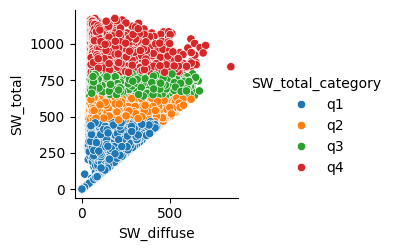

In [338]:
sns.pairplot(df, x_vars= "SW_diffuse", y_vars = "SW_total", hue= "SW_total_category")

## Part 2: Unsupervised Learning – Radiation Pattern Clustering (3 points)


In [339]:
# 2.1 K-Means Clustering (2 points)
# Use the normalized input features (excluding any SW variables) for K-Means clustering.
normalized_df = df
normalized_df = normalized_df.drop(["SW_direct", "SW_diffuse", "SW_total", "SW_total_category"], axis=1)
normalized_df=(normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
normalized_df

,SZA,AOD,COD,CLD_FRAC,UW,TO3,Pressure,BSA,WSA
0,0.353240,0.222356,0.149968,0.444123,0.291751,0.405407,0.784217,0.210811,0.260446
1,0.495735,0.308581,0.284571,0.726651,0.721282,0.396344,0.821436,0.201351,0.227019
2,0.387602,0.207566,0.124768,0.467166,0.784640,0.344805,0.899570,0.175676,0.199164
3,0.287576,0.213554,0.338044,0.584348,0.720758,0.439155,0.858018,0.202703,0.240947
4,0.188135,0.137388,0.045240,0.116830,0.083333,0.351927,0.478405,0.245946,0.286908
...,...,...,...,...,...,...,...,...,...
35219,0.530899,0.034020,0.145051,0.110331,0.335844,0.263186,0.827899,0.189189,0.229805
35220,0.922123,0.048629,0.024117,0.093540,0.121066,0.463072,0.902384,0.174324,0.175487
35221,0.882743,0.025881,0.014321,0.052107,0.339194,0.232140,0.827899,0.189189,0.229805
35222,0.962577,0.132295,0.084097,0.337916,0.055773,0.250568,0.197574,0.251351,0.246518


Use the elbow method to determine the optimal number of clusters.
* Elbow Method: Compute the sum of squared errors (SSE) or inertia for different values of K. Plot SSE against K. Choose K at the "elbow" point, where adding additional clusters does not substantially improve the SSE.

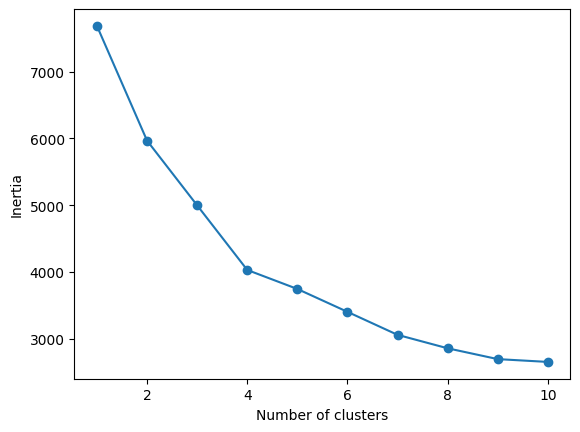

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(normalized_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [341]:
# Elbow is around 4, so we will pick 4 clusters, this is the smallest amount of clusters where an additional cluster is not associated with a large decrease in inertia

In [342]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(normalized_df)
y_kmeans = kmeans.predict(normalized_df)
normalized_df['Cluster'] = kmeans.fit_predict(X)
normalized_df

,SZA,AOD,COD,CLD_FRAC,UW,TO3,Pressure,BSA,WSA,Cluster
0,0.353240,0.222356,0.149968,0.444123,0.291751,0.405407,0.784217,0.210811,0.260446,2
1,0.495735,0.308581,0.284571,0.726651,0.721282,0.396344,0.821436,0.201351,0.227019,2
2,0.387602,0.207566,0.124768,0.467166,0.784640,0.344805,0.899570,0.175676,0.199164,0
3,0.287576,0.213554,0.338044,0.584348,0.720758,0.439155,0.858018,0.202703,0.240947,2
4,0.188135,0.137388,0.045240,0.116830,0.083333,0.351927,0.478405,0.245946,0.286908,3
...,...,...,...,...,...,...,...,...,...,...
35219,0.530899,0.034020,0.145051,0.110331,0.335844,0.263186,0.827899,0.189189,0.229805,0
35220,0.922123,0.048629,0.024117,0.093540,0.121066,0.463072,0.902384,0.174324,0.175487,2
35221,0.882743,0.025881,0.014321,0.052107,0.339194,0.232140,0.827899,0.189189,0.229805,0
35222,0.962577,0.132295,0.084097,0.337916,0.055773,0.250568,0.197574,0.251351,0.246518,1


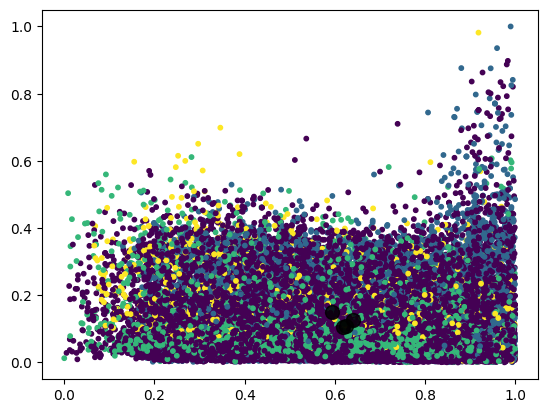

In [343]:
# Visualize the clusters using two selected features (e.g., SZA and AOD).
import seaborn as sns
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4)
kmeans.fit(normalized_df)
y_kmeans = kmeans.predict(normalized_df)

plt.scatter(normalized_df['SZA'], normalized_df['AOD'], c=y_kmeans, s=10)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.8);

In [344]:
pd.crosstab(normalized_df['Cluster'], df['SW_total_category'])

SW_total_category,q1,q2,q3,q4
Cluster,,,,
0,4726,4747,4636,4237
1,378,390,422,782
2,2881,2629,2555,2227
3,821,1040,1193,1560


### 2.2 Interpretation (1 point)
Describe the characteristics of the clusters.

Are the clusters meaningful in terms of solar radiation categories?

In [345]:
# The clusters are not clearly defined or sepreated. This, along with the cross tab showing the cliuster groups do not fall primarly in the respective quartile show that the clusters are not very meaningful in terms of solar radiation categories

## Part 3: Supervised Learning – Predicting Solar Radiation (4 points)
3.1 Regression – Predicting SW_total (2 points)

Train and evaluate two regression models:

DecisionTreeRegressor

RandomForestRegressor

Report metrics: RMSE and R² on a held-out test set.

Interpret feature importances from the random forest model.*

In [346]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree

In [347]:
#split dataset in features and target variable
feature_cols = ['SZA',	'AOD',	'COD',	'CLD_FRAC',	'UW',	'TO3',	'Pressure',	'BSA',	'WSA']
X = df[feature_cols] # Features
y = df.SW_total # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [348]:
# Create Decision Tree classifer object
clf = DecisionTreeRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(tree.export_text(clf))

|--- feature_0 <= 48.13
|   |--- feature_0 <= 32.80
|   |   |--- feature_3 <= 0.12
|   |   |   |--- feature_0 <= 22.48
|   |   |   |   |--- feature_4 <= 2.26
|   |   |   |   |   |--- feature_4 <= 1.08
|   |   |   |   |   |   |--- feature_0 <= 18.34
|   |   |   |   |   |   |   |--- feature_2 <= 0.37
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.36
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 12.73
|   |   |   |   |   |   |   |   |   |   |--- feature_4 <= 1.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- feature_4 >  1.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- feature_0 >  12.73
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 18.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  18.04
|   |   |   |   |   |   |   |   |   | 

In [349]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

rmse = np.sqrt(np.mean((y_test-y_pred)**2))
print(rmse)

141.49928790232343


In [350]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
r2 = r2_score(y_test, y_pred)
print(r2)

0.5891272103508269


3.2 Classification – Predicting SW_total_category (2 points)
Train and evaluate two classification models:

KNeighborsClassifier

GaussianNB

Report classification accuracy, precision, recall, and show a confusion matrix.

Discuss which model performs better and why.



In [351]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#split dataset in features and target variable
feature_cols = ['SZA',	'AOD',	'COD',	'CLD_FRAC',	'UW',	'TO3',	'Pressure',	'BSA',	'WSA']
X = df[feature_cols] # Features
y = df.SW_total_category # Target variable

# Split dataset into training set and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(Xtrain, ytrain)
ypred = knn.predict(Xtest)

print(ypred)
print(ytest)
print(knn.score(Xtest,ytest))

['q3' 'q4' 'q1' ... 'q4' 'q1' 'q2']
29701    q4
2932     q4
34473    q1
23257    q3
27975    q4
         ..
11420    q4
3027     q2
18993    q4
15687    q2
793      q2
Name: SW_total_category, Length: 7045, dtype: category
Categories (4, object): ['q1' < 'q2' < 'q3' < 'q4']
0.6029808374733854


In [352]:
conf_matrix = pd.crosstab(ytest, ypred, rownames=['Actual'], colnames=['Predicted'])
print(conf_matrix)

Predicted    q1   q2   q3    q4
Actual                         
q1         1370  299   71    24
q2          615  852  238    41
q3          176  513  917   154
q4           70  131  465  1109


In [353]:
precisions = {}
recalls = {}

for label in conf_matrix.index:
    tp = conf_matrix.loc[label, label] if label in conf_matrix.columns else 0
    fp = conf_matrix[label].sum() - tp if label in conf_matrix.columns else 0
    fn = conf_matrix.loc[label].sum() - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions[label] = precision
    recalls[label] = recall


In [354]:
# Predict on the test set
ypred = knn.predict(Xtest)

# Accuracy
accuracy = accuracy_score(ytest, ypred)

# Precision (macro-averaged)
precision = precision_score(ytest, ypred, average='macro')

# Recall (macro-averaged)
recall = recall_score(ytest, ypred, average='macro')

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, ypred, labels=sorted(y.unique()))
conf_matrix_df = pd.DataFrame(conf_matrix, index=sorted(y.unique()), columns=sorted(y.unique()))


# Classification Report
print("\nClassification Report:")
print(classification_report(ytest, ypred))


Classification Report:
              precision    recall  f1-score   support

          q1       0.61      0.78      0.69      1764
          q2       0.47      0.49      0.48      1746
          q3       0.54      0.52      0.53      1760
          q4       0.84      0.62      0.71      1775

    accuracy                           0.60      7045
   macro avg       0.62      0.60      0.60      7045
weighted avg       0.62      0.60      0.60      7045



In [355]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np

# Split dataset into features and target
feature_cols = ['SZA', 'AOD', 'COD', 'CLD_FRAC', 'UW', 'TO3', 'Pressure', 'BSA', 'WSA']
X = df[feature_cols]
y = df['SW_total_category']

# Split into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)

# Predict on the test set
ypred = gnb.predict(Xtest)

# Accuracy
accuracy = accuracy_score(ytest, ypred)

# Precision (macro-averaged: good for multi-class)
precision = precision_score(ytest, ypred, average='macro')

# Recall (macro-averaged)
recall = recall_score(ytest, ypred, average='macro')

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, ypred, labels=sorted(y.unique()))
conf_matrix_df = pd.DataFrame(conf_matrix, index=sorted(y.unique()), columns=sorted(y.unique()))

In [356]:
# Classification report
print("\nClassification Report:")
print(classification_report(ytest, ypred))


Classification Report:
              precision    recall  f1-score   support

          q1       0.78      0.71      0.74      1764
          q2       0.56      0.61      0.58      1746
          q3       0.54      0.54      0.54      1760
          q4       0.76      0.77      0.77      1775

    accuracy                           0.66      7045
   macro avg       0.66      0.66      0.66      7045
weighted avg       0.66      0.66      0.66      7045



The Gausian model had slighlty higher accuracy, with 66% as opposed to KKN with 60%. In order to choose what model to use, it's important to note what each model performs well on and not. For the KNN, precision, recall, f1-score, and accuracy are all less than gaussian model. So the GM is a better choice, however, if precision for example was the most improtant metric and it was better on the KNN, even though accuracy was slightly lower, it could make the KNN a better model.


Part 4: Reflection and Recommendation (2 points)
Write a short summary (100–200 words):

Which input features are most important for predicting total shortwave radiation?

Are there clear patterns in the clusters or classification groups?

Based on your results, what modeling strategy would you recommend for solar radiation prediction?

Based on the features and classification results, SZA (Solar Zenith Angle), AOD (Aerosol Optical Depth), and COD (Cloud Optical Depth) are very most important input features in predicting total shortwave radiation (SW_total). These features play a key role in determining the amount of solar radiation that reached the Earth's surface by influencing the amount of scattering and absorption. The clusters created through K-means clustering did not reveal meaningful patterns in terms of solar radiation categories. The clusters did not align well with the quartile breakdown of the total shortwave radiation (SW_total), as seen in the cross-tabulation. This suggests that the clustering method may not be suitable for capturing distinct groups related to radiation levels. For predicting total shortwave radiation, the Gaussian Naive Bayes (GNB) model is the strongest model, with 66% accuracy and that would be my recommendation.